Practice with converting multiple tiffs into arrays and slicing and dicing data to query between layers. Ie. Where elevation is 100 m, and aspect is north, what is the average snow depth.

In [3]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import pandas as pd
import fiona
import os
from scipy import sparse
%matplotlib inline


In [145]:
be_dem = r"H:\Englishman\2021\DEMs\Baseline Master Dataset - WGS84\Englishman_3m_Snow_Free_DTM_WGS84_z10_Ellips.tif"
snow_depth = r"H:\Englishman\2021\GIS\sd_rasters_clean\EGM_p05_sd_clean.tif"
phase = "P01"
wshed = "EGM"
#shapefile is the basin used to mask the rasters, should include the total lidar area if not a sub basin
basin = "fishtail.shp"
mask_directory = r"H:\Englishman\2021\GIS\masks"
out_directory_swe_tables = r"H:\Englishman\2021\Analysis\swe_tables"

name = wshed + "_" + str(phase)

In [146]:
#update these numbers w. swe multiplier and 
swe_multiplier = 0.57
lower_multiplier = .554
upper_multiplier = .589
resolution = 3
lm = lower_multiplier/swe_multiplier 
um = upper_multiplier/swe_multiplier

In [147]:
print("lm: " + str(lm))
print("um: " + str(um))

lm: 0.9719298245614036
um: 1.0333333333333334


In [45]:
# def calculate_aspect(DEM):
#     gdal.DEMProcessing('aspect.tif', DEM, 'aspect')
#     with rio.open('aspect.tif') as dataset:
#         aspect=dataset.read(1)
#         aspect_meta = dataset.meta    
#         aspect_meta.update({"driver": "GTiff", "height": aspect.shape[0], "width": aspect.shape[1]})
#     return aspect

In [149]:
#Testing the aspect calculator to spit out the masked aspect grid 
def calculate_aspect(DEM, mask_coords):
    gdal.DEMProcessing('aspect.tif', DEM, 'aspect')
    with rio.open("aspect.tif") as src:
        raster_image, raster_transform = rio.mask.mask(src, mask_coords, crop=True)
        return raster_image

In [148]:
aspect = calculate_aspect(be_dem, mask_coords)

In [150]:
aspect = aspect[0,:,:]
display(aspect.shape)

(1041, 1088)

In [151]:
#extract the cooridnates of a shapefile
def coords (mask_directory, basin):
    os.chdir(mask_directory)
    with fiona.open(basin) as shapefile:
        for feature in shapefile:
            shapes = [feature["geometry"]]
    return shapes

In [152]:
mask_coords = coords(mask_directory, basin)
display(mask_coords)
type(mask_coords)

[{'type': 'Polygon',
  'coordinates': [[(384386.8869000003, 5452961.150699999),
    (384252.8909999998, 5452998.107999999),
    (384234.9894000003, 5453007.3299),
    (384222.45999999996, 5453004.390000001),
    (384215.9983999999, 5453001.769099999),
    (384181.0385999996, 5453011.132200001),
    (384169.9254999999, 5453017.162699999),
    (384143.3287000004, 5453047.9396),
    (384134.4003999997, 5453124.1537999995),
    (384147.7703, 5453139.1241),
    (384147.36760000046, 5453158.859999999),
    (384147.96740000043, 5453188.2487),
    (384141.7599999998, 5453213.7118),
    (384135.5800000001, 5453226.449999999),
    (384117.45999999996, 5453250.3299),
    (384116.1665000003, 5453252.3027),
    (384116.5625, 5453252.6921),
    (384117.85780000035, 5453254.0208),
    (384119.1325000003, 5453255.3694),
    (384120.3808000004, 5453256.744999999),
    (384122.22449999955, 5453258.836200001),
    (384123.44020000007, 5453260.241800001),
    (384124.3696999997, 5453261.355900001),
    (3

list

In [1]:
%%time
def open_masked_raster_array(tif):
    with rio.open(tif) as src:
        raster_image, raster_transform = rio.mask.mask(src, mask_coords, crop=True)
        raster_meta = src.meta
        raster_crs = src.crs
        raster_extent = rio.plot.plotting_extent(src)
        return raster_image

CPU times: total: 0 ns
Wall time: 0 ns


In [154]:
%%time
be_dem = open_masked_raster_array(be_dem)
be_dem = be_dem[0,:,:]
display(be_dem)
display(be_dem.shape)


array([[-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       ...,
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38]], dtype=float32)

(1041, 1088)

CPU times: total: 15.6 ms
Wall time: 29.9 ms


In [155]:
snow_depth = open_masked_raster_array(snow_depth)
snow_depth = snow_depth[0,:,:]
display(snow_depth)
display(snow_depth.shape)


array([[-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       ...,
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.]], dtype=float32)

(1041, 1088)

numpy.ndarray

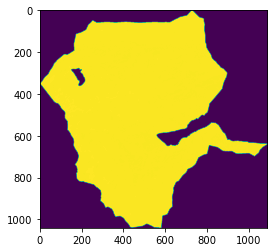

In [118]:
display(type(snow_depth))
plt.imshow(snow_depth)

In [2]:
be_dem[snow_depth == -999] = np.nan
aspect[snow_depth == -999] = np.nan
snow_depth[snow_depth == -999]= np.nan



NameError: name 'np' is not defined

In [157]:
be_dem.shape == snow_depth.shape
be_dem.shape == aspect.shape

True

In [158]:
#unravel the rasters
be_dem_ravel = np.ravel(be_dem)
aspect_ravel = np.ravel(aspect)
snow_depth_ravel = np.ravel(snow_depth)

In [159]:
print("BAREEARTH:" + str(np.shape(be_dem_ravel)))
print("ASPECT:" + str(np.shape(aspect_ravel)))
print("SNOWDEPTH:" + str(np.shape(snow_depth_ravel)))

BAREEARTH:(1132608,)
ASPECT:(1132608,)
SNOWDEPTH:(1132608,)


Video to watch on how to clip rasters to extent of a shapefile w. gdalwarp
https://www.google.com/search?client=firefox-b-e&q=gdalwarp+clip+raster#kpvalbx=_yJXwYc7gB8K90PEPitqR6AI27

In [123]:
# print(np.shape(aspect))
# print(type(aspect[0,0]))
# print(aspect[2000,1000])
# display(np.count_nonzero(aspect == -9999))

(1041, 1088)
<class 'numpy.float32'>


IndexError: index 2000 is out of bounds for axis 0 with size 1041

In [ ]:
be_dem = gdal.Open(be_dem).ReadAsArray()

In [ ]:
snow_depth = gdal.Open(snow_depth).ReadAsArray()

In [ ]:
mask = gdal.Open(snow_depth).ReadAsArray()

In [ ]:
#be_dem[mask >= 1] = np.nan
print(np.shape(mask))
print(np.shape(be_dem))
print(np.unique(mask))
display(type(mask))

In [ ]:
print(be_dem[2000])
print(snow_depth[2000])

In [ ]:
np.ma?

In [ ]:
#masking arrays by valid values only
#be_dem[be_dem == -3.4028234663852886e+38] = np.nan
#aspect[aspect == -3.4028234663852886e+38] = np.nan
#could use this method for masking by the smaller value, ie where there is snow depth, no elevation
#snow_depth[snow_depth == -999] = np.nan

#unravel thearrays
#be_dem_ravel = np.ravel(be_dem)
#aspect_ravel = np.ravel(aspect)
#snow_depth_ravel = np.ravel(snow_depth)

#display(be_dem_ravel)
#plt.hist(be_dem_ravel, 50)
#plt.hist(aspect_ravel,50)
#plt.hist(snow_depth_ravel, 50)



In [ ]:
#masking arrays by valid values only
#be_dem[be_dem == -3.4028234663852886e+38] = np.nan
#aspect[aspect == -3.4028234663852886e+38] = np.nan
#could use this method for masking by the smaller value, ie where there is snow depth, no elevation
be_dem[snow_depth == -999] = np.nan
aspect[snow_depth == -999] = np.nan
snow_depth[snow_depth == -999] = np.nan

#unravel thearrays
be_dem_ravel = np.ravel(be_dem)
aspect_ravel = np.ravel(aspect)
snow_depth_ravel = np.ravel(snow_depth)

#display(be_dem_ravel)
#plt.hist(be_dem_ravel, 50)
plt.hist(aspect_ravel,50)
#plt.hist(snow_depth_ravel, 50)

In [ ]:
print("BAREEARTH:" + str(np.shape(be_dem_ravel)))
print("ASPECT:" + str(np.shape(aspect_ravel)))
print("SNOWDEPTH:" + str(np.shape(snow_depth_ravel)))

In [160]:
df = pd.DataFrame({"Elev": be_dem_ravel, "Asp": aspect_ravel, "SD": snow_depth_ravel})
df = df.dropna()
#df = df.drop_duplicates()
df = df.reset_index(drop=False)
df.to_csv(r"H:\Englishman\2021\Analysis\swe_tables\test_df.csv")
display(df)

,index,Elev,Asp,SD
0,1813,1328.150024,199.659485,0.006714
1,1814,1327.020020,187.572876,1.793091
2,1815,1328.089966,212.519577,1.551270
3,2899,1323.880005,221.949677,0.480957
4,2900,1325.540039,198.791168,0.008179
...,...,...,...,...
585517,1131006,1509.660034,341.936737,0.031494
585518,1131007,1509.380005,28.518105,0.003784
585519,1131008,1509.199951,46.109333,-0.030151
585520,1131009,1508.880005,40.584156,-0.057739


In [161]:
#find min and max value of elevation
min = int(df["Elev"].min())
max = int(df["Elev"].max())

# rounding to nearest 100 
df['zbin'] = round(df["Elev"], -2)
print (df)

          index         Elev         Asp        SD    zbin
0          1813  1328.150024  199.659485  0.006714  1300.0
1          1814  1327.020020  187.572876  1.793091  1300.0
2          1815  1328.089966  212.519577  1.551270  1300.0
3          2899  1323.880005  221.949677  0.480957  1300.0
4          2900  1325.540039  198.791168  0.008179  1300.0
...         ...          ...         ...       ...     ...
585517  1131006  1509.660034  341.936737  0.031494  1500.0
585518  1131007  1509.380005   28.518105  0.003784  1500.0
585519  1131008  1509.199951   46.109333 -0.030151  1500.0
585520  1131009  1508.880005   40.584156 -0.057739  1500.0
585521  1131010  1508.599976   25.714340 -0.097412  1500.0

[585522 rows x 5 columns]


C:\Anaconda\envs\geog650\lib\site-packages\pandas\core\series.py:2393: RuntimeWarning: overflow encountered in multiply
  result = self._values.round(decimals)


In [162]:
# create function to change aspect from degrees to a letter aspect, note this is gdals aspect!!!

def aspect(df, old_col, new_col):
    conditions_asp = [
        df[old_col] <= -9999,
        df[old_col] <= 22.5,
        df[old_col] <= 67.5,
        df[old_col] <= 112.5,
        df[old_col] <= 157.5,
        df[old_col] <= 202.5,
        df[old_col] <= 247.5,
        df[old_col] <= 292.5,
        df[old_col] <= 337.5,
        df[old_col] <= 360]

    values_asp = ["Flat", "North", "Northeast", "East", "Southeast", "South", "Southwest", "West", "Northwest", "North"]
    df[new_col] = np.select(conditions_asp, values_asp)

aspect(df, "Asp", "Aspect")
display(df)

,index,Elev,Asp,SD,zbin,Aspect
0,1813,1328.150024,199.659485,0.006714,1300.0,South
1,1814,1327.020020,187.572876,1.793091,1300.0,South
2,1815,1328.089966,212.519577,1.551270,1300.0,Southwest
3,2899,1323.880005,221.949677,0.480957,1300.0,Southwest
4,2900,1325.540039,198.791168,0.008179,1300.0,South
...,...,...,...,...,...,...
585517,1131006,1509.660034,341.936737,0.031494,1500.0,North
585518,1131007,1509.380005,28.518105,0.003784,1500.0,Northeast
585519,1131008,1509.199951,46.109333,-0.030151,1500.0,Northeast
585520,1131009,1508.880005,40.584156,-0.057739,1500.0,Northeast


In [163]:
# Calculate swe and water volume based on the swe multiplier used, aswell as the raster resolution
display(swe_multiplier)
display(resolution)
df["swe"]= df["SD"]*swe_multiplier
df["swe_mm"]=df["swe"]*1000
df["water_vol"]= df["swe"]*(resolution*resolution)
df["lower_wv"]=df["water_vol"]*lm
df["upper_wv"]=df["water_vol"]*um

df = df.sort_values(by=['Asp'])


display(df)

0.57

3

,index,Elev,Asp,SD,zbin,Aspect,swe,swe_mm,water_vol,lower_wv,upper_wv
61307,167253,912.169983,-9999.000000,0.293660,900.0,Flat,0.167386,167.386475,1.506478,1.464191,1.556694
254782,441772,1700.430054,-9999.000000,0.760111,1700.0,Flat,0.433263,433.263245,3.899369,3.789913,4.029348
254781,441771,1696.900024,-9999.000000,0.655762,1700.0,Flat,0.373784,373.784180,3.364058,3.269628,3.476193
254780,441484,1100.989990,-9999.000000,2.777222,1100.0,Flat,1.583016,1583.016357,14.247148,13.847228,14.722052
380319,643726,986.478943,-9999.000000,0.440239,1000.0,Flat,0.250936,250.935944,2.258424,2.195029,2.333704
...,...,...,...,...,...,...,...,...,...,...,...
297734,503913,1566.510010,359.997498,4.652222,1600.0,North,2.651766,2651.766357,23.865896,23.195976,24.661425
224523,401967,1374.280029,359.997650,1.387451,1400.0,North,0.790847,790.847168,7.117625,6.917832,7.354879
460926,765534,1111.969971,359.998474,0.148193,1100.0,North,0.084470,84.470215,0.760232,0.738892,0.785573
439336,730636,1011.559998,359.998627,0.150513,1000.0,North,0.085792,85.792236,0.772130,0.750456,0.797868


Next Steps:
 - Summarize by Elevation and Aspect
 - Ideally have this in a loop form to find every pair of elevation band and aspect
 

In [142]:
sum_wv = round(df.groupby(by=["zbin", "Aspect"],as_index=False)["water_vol"].sum(),2)
sum_lm_wv = round(df.groupby(by=["zbin", "Aspect"],as_index=False)["lower_wv"].sum(),2)
round(df.groupby(by=["zbin", "Aspect"],as_index=False)["upper_wv"].sum(),2)
average = df.groupby(by=["zbin", "Aspect"],as_index=False)["swe_mm"].mean()
display(average)

KeyError: 'zbin'

In [129]:
#creates the pivot table
sum = round(pd.crosstab(
      index=df['zbin'], columns=df['Aspect'],
      values=df['water_vol'], aggfunc='sum').fillna(0),2)
sum = sum[["Flat", "North", "Northeast", "East", "Southeast", "South", "Southwest", "West", "Northwest"]]
display(sum)

sum.to_csv("test_crosstab.csv")

Aspect,Flat,North,Northeast,East,Southeast,South,Southwest,West,Northwest
zbin,,,,,,,,,
-inf,450.130005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
800.0,0.000000,5.070000,3.030000,4.800000,8.920000,1.690000,0.770000,-0.060000,0.000000
900.0,18.940001,1632.060059,1081.699951,763.090027,1074.050049,436.670013,35.189999,1.210000,92.860001
1000.0,107.720001,7913.709961,4348.490234,2799.290039,5711.819824,6820.069824,568.090027,675.469971,5026.080078
1100.0,27.360001,10479.559570,6426.879883,5340.319824,9988.519531,12901.459961,1858.359985,2023.369995,10425.940430
1200.0,35.590000,19212.740234,11362.040039,11081.070312,15883.559570,16882.320312,3338.439941,3539.020020,14285.099609
1300.0,113.739998,26635.949219,25803.039062,19036.820312,16149.990234,14758.629883,3894.800049,3466.010010,19430.160156
1400.0,300.690002,39512.660156,50864.171875,28749.400391,19050.140625,13014.469727,3115.459961,2559.709961,19256.509766
1500.0,114.330002,37495.421875,64938.121094,46157.621094,21487.939453,8953.019531,2401.669922,1080.140015,10465.320312


In [165]:
def pivot_table(value_col, agg_func,name, directory):
    output_name = name + "_" + value_col + "_" + agg_func + ".csv"
    sum = round(pd.crosstab(
      index=df['zbin'], columns=df['Aspect'],
      values=df[value_col], aggfunc=agg_func, margins=True,margins_name="Total").fillna(0),2)
    sum = sum[["Flat", "North", "Northeast", "East", "Southeast", "South", "Southwest", "West", "Northwest","Total"]]
    display(sum)
    
    output = os.path.join(directory, output_name)
    sum.to_csv(output)

out_directory_swe_tables = r"H:\Englishman\2021\Analysis\swe_tables"
pivot_table("water_vol", "sum", name, out_directory_swe_tables)
pivot_table("lower_wv", "sum", name,out_directory_swe_tables)
pivot_table("water_vol", "count", name, out_directory_swe_tables)

KeyError: "['SWE_mm'] not in index"

In [ ]:
pivot = summary.pivot(index="zbin", columns="Aspect", values="water_vol")
pivot.to_csv("test_pivot.csv")